In [1]:
import pandas as pd
from lxml import html
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
import gensim
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter,defaultdict
from string import punctuation
import os
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
%matplotlib inline

morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return ' '.join(words)

def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]

    return ' '.join(words)


Для обучения векторных представлений необходимо большое количество текста. Чем больше текста, тем лучше предтавления получатся.  
Возьмем ~7к новостных статей. Это все ещё маленький корпус, но для обучения он подходит (на нем можно достаточно быстро попробовать разные методы). 

In [3]:
data_rt = pd.read_csv('news_texts.csv')

In [ ]:
# data_rt['content_norm'] = data_rt['content'].apply(normalize)

In [4]:
data_rt.dropna(inplace=True)

## Матричные разложения

Попробуем сначала матричные разложения. В SVD и в NMF одна из получаемых матриц имеет размерность (количество слов, количесто "тем"). Вектора из этих матриц и будут искомыми эбмедингами.

Для построение изнчальной матрицы слова на документы воспользуемся CountVectorizer из sklearn.

In [5]:
cv = CountVectorizer(min_df=3, max_df=0.4, max_features=1000)
X = cv.fit_transform(data_rt['content_norm'])

In [6]:
X.shape

(7212, 1000)

Разложим матрицу. Сначала попробуем только две размерности, чтобы визуализировать вектора.

In [7]:
svd = TruncatedSVD(200)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=200, n_iter=5,
       random_state=None, tol=0.0)

In [ ]:
# svd2 = PCA(2)
# svd2.fit(svd.components_)

In [ ]:
# tsne = TSNE(2).fit_transform(svd.components_.T)

In [8]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

Попробуем визуализировать полученные вектора. Все слова визуализировать не получится, но можно попробовать взять какое-то количество случайных слов.

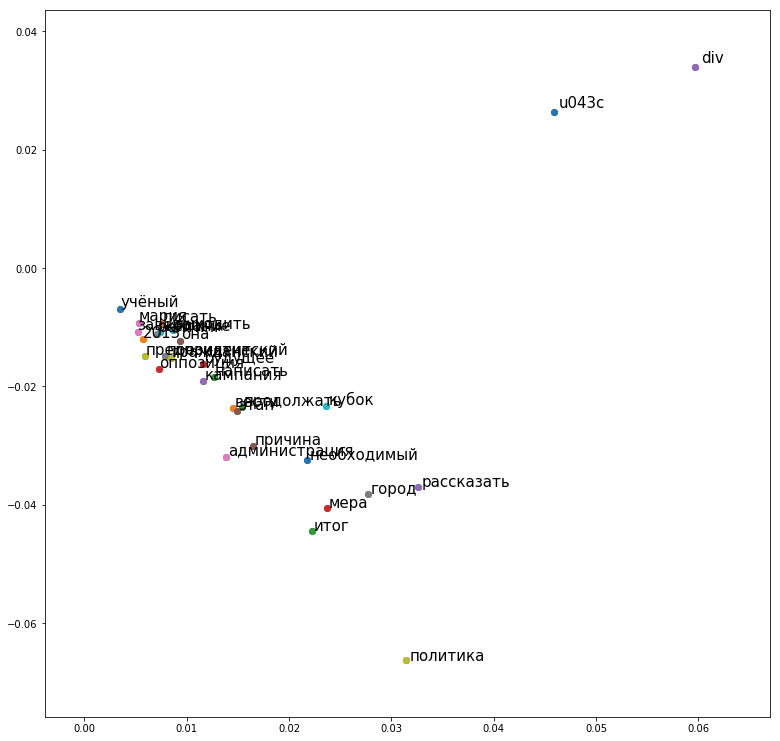

In [12]:
random_inds = np.random.choice(range(len(id2word)), 30, replace=False)
res = svd.components_.T[random_inds]
# res = tsne[random_inds]

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(random_inds):
    x, y = res[i, 0], res[i, 1]
    plt.scatter(x, y)
    
    plt.annotate(id2word[coor], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

Получается не очень красиво. Почти все слова сбиваются в кучу. 

Но визуализация ещё ничего не говорит. Посмотрим на близкие слова.

Перестроим разложения с большим количеством параметров.

In [14]:
nmf = NMF(50)
nmf.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [13]:
svd = TruncatedSVD(50)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0)

In [16]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

In [17]:
id2vec_svd = nmf.components_.T

In [18]:
id2vec_nmf = svd.components_.T

In [19]:
def most_similar(word, id2vec):
    similar = [id2word[i] for i in cosine_distances(id2vec[word2id[word]].reshape(1, -1), id2vec).argsort()[0][:10]]
    return similar

In [20]:
most_similar('спорт', id2vec_svd)

['спорт',
 'спортивный',
 'олимпийский',
 'спортсмен',
 'олимпиада',
 'мокнуть',
 'флаг',
 'пхёнчхан',
 'сочи',
 'допинг']

In [21]:
most_similar('спорт', id2vec_nmf)

['спорт',
 'спортивный',
 'спортсмен',
 'допинг',
 'флаг',
 'мокнуть',
 'федерация',
 'олимпийский',
 'соревнование',
 'участвовать']

По похожим словам вектора выглядят достаточно хорошо.

Попробуем ещё кластеризовть полученные слова. Одна из метрик хороших векторов - их кластеризуемость (т.е. насколько хорошие получаются кластеры, можно ли сразу дать им какое-то название).

Сделаем кластеризацию с помощью MiniBatchKmeans.

In [22]:
cluster = MiniBatchKMeans(500, n_init=2, verbose=1, max_no_improvement=100, reassignment_ratio=0.4)
cluster.fit(nmf.components_.T)

Init 1/2 with method: k-means++


/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:1556: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/2: 71.201429
Init 2/2 with method: k-means++


/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:1556: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


Inertia for init 2/2: 76.917550
Minibatch iteration 1/1000: mean batch inertia: 1.525456, ewa inertia: 1.525456 
Minibatch iteration 2/1000: mean batch inertia: 1.517904, ewa inertia: 1.523947 
Minibatch iteration 3/1000: mean batch inertia: 1.021679, ewa inertia: 1.423594 
Minibatch iteration 4/1000: mean batch inertia: 1.014010, ewa inertia: 1.341759 
Minibatch iteration 5/1000: mean batch inertia: 1.892670, ewa inertia: 1.451831 
Minibatch iteration 6/1000: mean batch inertia: 0.503675, ewa inertia: 1.262389 
Minibatch iteration 7/1000: mean batch inertia: 1.312351, ewa inertia: 1.272371 
Minibatch iteration 8/1000: mean batch inertia: 1.000552, ewa inertia: 1.218062 
Minibatch iteration 9/1000: mean batch inertia: 0.746311, ewa inertia: 1.123806 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/1000: mean batch inertia: 0.625532, ewa inertia: 1.024251 
Minibatch iteration 11/1000: mean batch inertia: 0.723841, ewa inertia: 0.964229 
Minibatch iteration 12/10

Minibatch iteration 112/1000: mean batch inertia: 0.989319, ewa inertia: 1.415885 
Converged (lack of improvement in inertia) at iteration 112/1000
Computing label assignment and total inertia


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=100,
        n_clusters=500, n_init=2, random_state=None,
        reassignment_ratio=0.4, tol=0.0, verbose=1)

Сохраним кластеры в текстовый файл и просто полистаем.

In [24]:

cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(id2word[i])

f = open('cluster_nmf.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

## Word2Vec и Fasttext

Проделаем тоже самое для ворд2века и фастекста. 

Интерфейс в gensim практически такой же как и в LDA. Только строить словарь не нужно.

In [ ]:
fast_text = gensim.models.FastText([text.split() for text in data_rt['content_norm']], size=50, min_n=4, max_n=8)
w2v = gensim.models.Word2Vec([text.split() for text in data_rt['content_norm']], size=50, sg=1)


In [ ]:
random_words = np.random.choice(w2v.wv.index2word, 100, replace=False)
res = w2v[random_words]
# res = TSNE(2).fit_transform(res)

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(res):
    x, y = coor
    plt.scatter(x, y)
    
    plt.annotate(random_words[i], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

Опять же ничего хорошего на график не рисуется.

Поставим size побольше и посмотрим на близкие слова.

In [ ]:
fast_text = gensim.models.FastText([text.split() for text in data_rt['content_norm']], size=50, min_n=4, max_n=8)
w2v = gensim.models.Word2Vec([text.split() for text in data_rt['content_norm']], size=50, sg=1)


In [ ]:
fast_text.most_similar('путин')

In [ ]:
w2v.most_similar('путин')

Ну и на кластеры давайте тоже посмотрим.

In [ ]:
vocab = fast_text.wv.index2word
matrix = np.zeros((len(vocab), 50))

for i, word in enumerate(vocab):
    if word in vocab:
        matrix[i] = fast_text[word]

In [ ]:
cluster = MiniBatchKMeans(1000, n_init=2, verbose=1, max_no_improvement=300, reassignment_ratio=0.4)
cluster.fit(matrix)
cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(vocab[i])

f = open('cluster_ft.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

Преимущество фастекста в том, что он учитывает символьные нграммы (что примерно равно учету морфологии). Попробуем подать ему на вход ненормализованные тексты.

In [ ]:
corpus = [text.split() for text in data_rt['content'].apply(tokenize)]
fast_text = gensim.models.FastText(corpus, size=50, min_n=4, max_n=8)

In [ ]:
vocab = fast_text.wv.index2word
matrix = np.zeros((len(vocab), 50))

for i, word in enumerate(vocab):
    if word in vocab:
        matrix[i] = fast_text[word]
        
cluster = MiniBatchKMeans(1000, n_init=2, verbose=1, max_no_improvement=300, reassignment_ratio=0.4)
cluster.fit(matrix)
cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(vocab[i])

f = open('cluster_ft.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

### Векторные представления в настоящей задаче

Все вышеперечисленое относится к intrinsic (внутренним) метрикам. Есть также много других схожих (аналогии, корреляция с оценками людей и т.д). Но эти метрики не всегда показывают какой из методов сработает в реальной задаче. Поэтому при выборе методов и подборе параметров лучше ориентироваться на оценки качества решаемой задачи.

Проверим как все эти методы работают на задаче определения парафразов (предложений, которые выражают одно и то же, но не равны друг другу).

Данные взяты вот отсюда: http://paraphraser.ru/

Коллекция состоит из пар предложения (заголвков статей) и метки класса (-1,0,1). -1 не парафраз, 1 - парафраз, 0 - что-то непонятное.

In [ ]:
corpus_xml = html.fromstring(open('paraphraser/paraphrases.xml', 'rb').read())
texts_1 = []
texts_2 = []
classes = []

for p in corpus_xml.xpath('//paraphrase'):
    texts_1.append(p.xpath('./value[@name="text_1"]/text()')[0])
    texts_2.append(p.xpath('./value[@name="text_2"]/text()')[0])
    classes.append(p.xpath('./value[@name="class"]/text()')[0])
    
data = pd.DataFrame({'text_1':texts_1, 'text_2':texts_2, 'label':classes})

In [ ]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

Тексты короткие и их маловато, поэтому возьмем модели, обученные на новостных текстах.

Для решения задачи преобразуем каждый текст и конкатенируем их векторы.

### SVD

In [ ]:
X_text_1 = svd.transform(tfidf.transform(data['text_1_norm']))
X_text_2 = svd.transform(tfidf.transform(data['text_2_norm']))

X_text = np.concatenate([X_text_1, X_text_2], axis=1)

In [ ]:
X_text.shape

In [ ]:
y = data['label'].values
print(y.shape)

Для простоты не будем использовать кросс-валидацию, а просто разобьем на трейн и тест. Зафиксируем сид, чтобы каждый раз получалось одинаковое разбиение.

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = LogisticRegression(C=1000, class_weight='balanced',  multi_class='auto')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=10,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


### NMF

Точно также (делаем пару векторов, конкатенируем, суём в логрег или рандом форест)

In [ ]:
X_text_1_nmf = nmf.transform(tfidf.transform(data['text_1_norm']))
X_text_2_nmf = nmf.transform(tfidf.transform(data['text_2_norm']))

X_text_nmf = np.concatenate([X_text_1_nmf, X_text_2_nmf], axis=1)

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_nmf, y,random_state=1)
clf = LogisticRegression(C=10000, class_weight='balanced',  multi_class='auto')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_nmf, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


### Word2Vec и Fastext

Преобразование текста в вектор с помощью w2v и fasttext не тривиальная задача. Самый простой и распространенный способ - усреднение отдельных векторов слов. Можно ещё использовать tfidf отдельных слов, для взвешивания отдельных векторов (чтобы частотные векторы не утягивали все на себя).

In [ ]:
def get_embedding(text, model, dim):
    text = text.split()
    
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [ ]:
dim = 50
X_text_1_w2v = np.zeros((len(data['text_1_norm']), dim))
X_text_2_w2v = np.zeros((len(data['text_2_norm']), dim))

for i, text in enumerate(data['text_1_norm'].values):
    X_text_1_w2v[i] = get_embedding(text, w2v, dim)
    
for i, text in enumerate(data['text_2_norm'].values):
    X_text_2_w2v[i] = get_embedding(text, w2v, dim)

In [ ]:
X_text_w2v = np.concatenate([X_text_1_w2v, X_text_2_w2v], axis=1)

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = LogisticRegression(C=1000,  multi_class='auto')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


In [ ]:
dim = 50
data['text_1_notnorm'] = data['text_1'].apply(tokenize)
data['text_2_notnorm'] = data['text_2'].apply(tokenize)

X_text_1_ft = np.zeros((len(data['text_1_notnorm']), dim))
X_text_2_ft = np.zeros((len(data['text_2_notnorm']), dim))

for i, text in enumerate(data['text_1_notnorm'].values):
    X_text_1_ft[i] = get_embedding(text, fast_text, dim)
    
for i, text in enumerate(data['text_2_notnorm'].values):
    X_text_2_ft[i] = get_embedding(text, fast_text, dim)

In [ ]:
X_text_ft = np.concatenate([X_text_1_ft, X_text_2_ft], axis=1)

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_ft, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))
